In [1]:
#importing libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
from scipy.stats import iqr, skew, kurtosis, shapiro, normaltest

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1d
from tensorflow.keras.optimizers import Adam


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier

2022-04-12 14:18:47.011612: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
#generating GRB peak with poisson noise


def gen_signal(N, x0, w, A, bkg, peak=False):
    x = np.arange(N)
    y = np.ones(N) * bkg 
    
    if peak:
        y_peak = np.exp(-(x-x0)/w) * A
        y_peak[:x0] = 0
        y += y_peak
        
    y = np.random.poisson(y)

    return x, y

In [3]:
#random constant vales

#Number of data
N_data = 10000
df = pd.DataFrame(columns=["x0", "w", "A", "bkg", "GRB"], index=range(N_data))

for i in range(N_data):
    df["x0"].loc[i] = np.random.randint(10, 50)
    df["w"].loc[i] = np.random.uniform(10, 20)
    df["A"].loc[i] = np.random.uniform(7, 10)
    df["bkg"].loc[i] = np.random.uniform(10,15)
    df["GRB"].loc[i] = [True, False][np.random.randint(2)]
df[0:10]

,x0,w,A,bkg,GRB
0,42,12.694009,8.08307,13.777925,False
1,21,11.43444,7.313835,10.184488,False
2,10,16.706559,9.060301,10.910753,False
3,46,17.257081,8.025535,12.623473,False
4,43,18.859242,7.42481,10.993628,True
5,47,15.794543,9.549923,13.867159,True
6,46,11.127548,9.949697,14.461951,False
7,48,18.275816,9.887481,10.213424,True
8,46,18.112911,9.15143,13.159857,True
9,44,19.346533,9.113543,14.418978,True


In [4]:
#generating random data

#duration of peak window
N_tu = 100

data = []
for i in range(N_data):
    data.append(gen_signal(N=N_tu, 
                           x0=df.x0.loc[i], 
                           w=df.w.loc[i], 
                           A=df.A.loc[i], 
                           bkg=df.bkg.loc[i], 
                           peak=df.GRB.loc[i])[1])

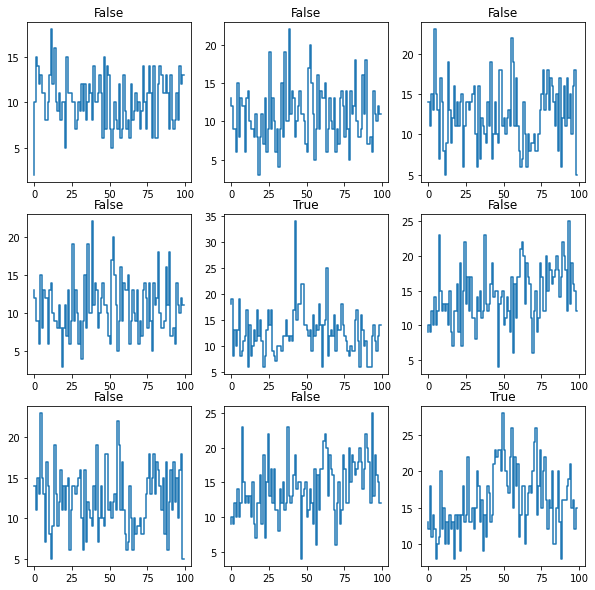

In [5]:
#9 samples of generated data
x = np.arange(N_tu)

fig, axs = plt.subplots(3,3,figsize=(10,10))
for i in range(3):
    for j in range(3):
        ind = (i+1)*(j+1)
        axs[i,j].set_title(df.GRB.loc[ind])
        axs[i,j].step(x, data[ind])

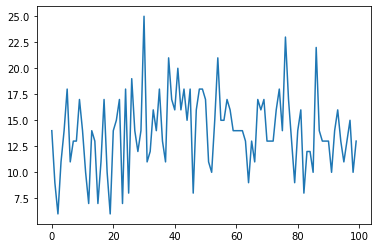

In [6]:
plt.plot(data[0])

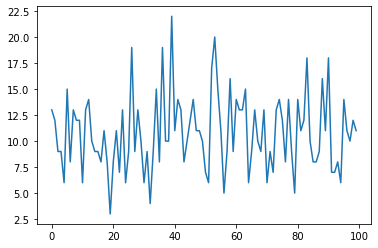

In [7]:
plt.plot(data[2])

In [8]:
shapiro_test = lambda x: shapiro(x)[0]
normal_test = lambda x: normaltest(x)[0]

features = {"std" : np.std,
            "IQR" : iqr, # difference between the 75th and 25th percentile
            "skewness" : skew, # for normally distributed data, the skewness should be about zero
            "kurtosis" : kurtosis, #  fourth central moment divided by the square of the variance
            "normaltest" : normal_test,
            "shapiro" : shapiro_test}


            
columns = ["std", "IQR", "skewness", "kurtosis", "normaltest", "shapiro"]
df_hist = pd.DataFrame(columns = columns, index=range(N_data))

for i, flux in enumerate(data):
    for f in features.keys():
        df_hist[f].loc[i] = features[f](flux)
    
df_hist    

,std,IQR,skewness,kurtosis,normaltest,shapiro
0,3.651904,4.25,0.194664,0.292976,1.513444,0.98085
1,2.823898,4.0,0.007469,-0.162701,0.005152,0.982358
2,3.633992,5.0,0.548008,0.261804,5.801131,0.972221
3,3.823336,5.0,0.205545,-0.347446,1.118415,0.98272
4,4.353206,4.25,1.421821,4.709087,41.472097,0.907979
...,...,...,...,...,...,...
9995,4.104863,4.25,0.113863,0.112418,0.555335,0.983339
9996,3.049115,3.25,0.48953,1.5449,10.221804,0.966067
9997,4.569672,5.25,0.334757,0.125183,2.367378,0.985443
9998,3.690528,6.0,0.498956,-0.419253,4.939342,0.964242


In [9]:
X = df_hist[["std", "IQR", "skewness", "kurtosis", "normaltest", "shapiro"]]
y = df["GRB"]

#encode target labels with value between 0 and n_classes-1
le = LabelEncoder()

#fit label encoder
le.fit(y)


#transform labels to normalized encoding (True = 1, False = 0)
y = le.transform(y) 

#splits data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
print(X_train.shape, X_test.shape)

(7500, 6) (2500, 6)


In [11]:
classifier = [("RFC", RandomForestClassifier())]
model = StackingClassifier(classifier)

model.fit(X_train, y_train)

StackingClassifier(estimators=[('RFC', RandomForestClassifier())])

In [12]:
y_pred = model.predict(X_test)
y_pred, sum(y_pred == y_test)/ len(y_pred)

(array([0, 0, 1, ..., 0, 1, 1]), 0.8352)

In [13]:
y_srov = y_pred-y_test 
A, B, C = sum(y_srov == 0), sum(y_srov == 1), sum(y_srov == -1)
A, B, C
NN = len(y_srov)
print('True Positive',A, A/NN)
print('True Negative', B, B/NN)
print('False Positive and Negative', C, C/NN)

True Positive 2088 0.8352
True Negative 213 0.0852
False Positive and Negative 199 0.0796


In [14]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.839     0.830     0.835      1253
           1      0.831     0.840     0.836      1247

    accuracy                          0.835      2500
   macro avg      0.835     0.835     0.835      2500
weighted avg      0.835     0.835     0.835      2500



In [15]:
res = cross_validate(model, X, y, cv=10)

score = res["test_score"]
"Crossvalidation score: {0:.3f} +/- {1:.3f}".format(np.mean(score), np.std(score))

'Crossvalidation score: 0.832 +/- 0.013'

[0.42561221 0.10465704 0.13862233 0.10203044 0.11871815 0.11035982]


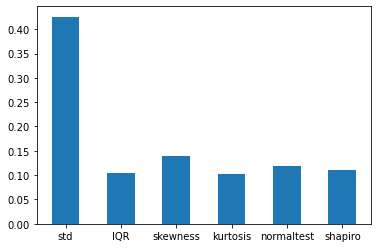

In [16]:
clf = ExtraTreesClassifier(random_state=2).fit(X,y)
print(clf.feature_importances_)
plt.bar(np.arange(6), clf.feature_importances_, 0.5)
plt.xticks(np.arange(6), X.columns);

In [17]:
res

{'fit_time': array([5.66179585, 5.40781593, 5.9725771 , 6.01161361, 5.5866487 ,
        6.06612706, 5.9003582 , 5.87963271, 5.98928094, 5.90341926]),
 'score_time': array([0.0254848 , 0.02567673, 0.02156711, 0.02516818, 0.0235796 ,
        0.02319789, 0.02829647, 0.02124238, 0.02287984, 0.02247071]),
 'test_score': array([0.826, 0.855, 0.815, 0.826, 0.837, 0.835, 0.847, 0.807, 0.836,
        0.837])}